# 03 - Imbalance Handling

Objective: compare multiple strategies to handle severe class imbalance without leaking information.

Methods:
- SMOTE on training data only
- Random undersampling (baseline)
- Class weights for algorithms that support it

We keep validation/test untouched by resampling.


In [1]:
import sklearn
print("sklearn:", sklearn.__version__)

sklearn: 1.8.0


In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from pathlib import Path
import json

PROCESSED_DIR = Path('../data/processed/new_analysis')

# Setup results directories
RESULTS_DIR = Path('../results')
METRICS_DIR = RESULTS_DIR / 'metrics'
FIGURES_DIR = RESULTS_DIR / 'figures'
METRICS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

X_train = pd.read_csv(PROCESSED_DIR / 'X_train_scaled.csv')
y_train = pd.read_csv(PROCESSED_DIR / 'y_train.csv').squeeze()

# Class weights (for use in later models)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Save class weights
class_weights_data = {
    'class_0_weight': float(class_weights[0]),
    'class_1_weight': float(class_weights[1]),
    'class_weight_dict': {str(k): float(v) for k, v in class_weight_dict.items()}
}
with open(METRICS_DIR / '03_class_weights.json', 'w') as f:
    json.dump(class_weights_data, f, indent=2)
print(f"Saved class weights to: {METRICS_DIR / '03_class_weights.json'}")

class_weight_dict

Saved class weights to: ..\results\metrics\03_class_weights.json


{0: np.float64(0.5008661206149896), 1: np.float64(289.14340101522845)}

Class
Non-Fraud    227451
Fraud           394
Name: count, dtype: int64

Saved figure to: ..\results\figures\03_original_class_distribution.png


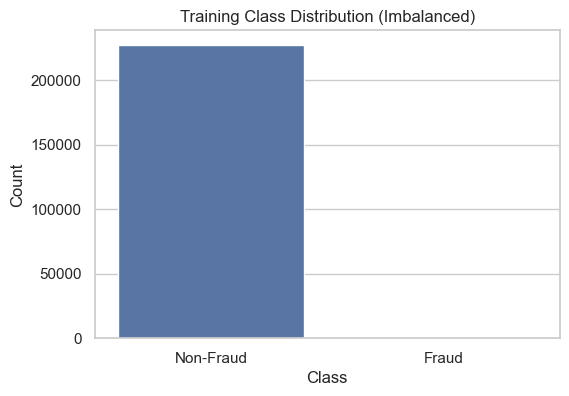

In [3]:
# Inspect imbalance before resampling
class_counts = y_train.value_counts().rename(index={0: 'Non-Fraud', 1: 'Fraud'})
display(class_counts)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, ax=ax)
ax.set_ylabel('Count')
ax.set_title('Training Class Distribution (Imbalanced)')

# Save figure
fig.savefig(FIGURES_DIR / '03_original_class_distribution.png', dpi=300, bbox_inches='tight')
print(f"Saved figure to: {FIGURES_DIR / '03_original_class_distribution.png'}")

plt.show()

In [4]:
# Simple SMOTE implementation on training data only
# For each minority sample, pick k-nearest minority neighbours and interpolate

def simple_smote(X, y, k_neighbors=5, random_state=42):
    rng = np.random.default_rng(random_state)
    X = np.asarray(X)
    y = np.asarray(y)

    minority_class = 1
    X_min = X[y == minority_class]
    X_maj = X[y == 0]

    n_min, n_maj = X_min.shape[0], X_maj.shape[0]
    n_samples_to_generate = n_maj - n_min
    if n_samples_to_generate <= 0:
        return X, y

    nn = NearestNeighbors(n_neighbors=min(k_neighbors, n_min))
    nn.fit(X_min)
    neigh_ind = nn.kneighbors(X_min, return_distance=False)

    synthetic = []
    for _ in range(n_samples_to_generate):
        i = rng.integers(0, n_min)
        xi = X_min[i]
        # pick one of its neighbours (excluding itself)
        neigh_choices = neigh_ind[i][1:] if neigh_ind.shape[1] > 1 else neigh_ind[i]
        j = rng.choice(neigh_choices)
        xj = X_min[j]
        lam = rng.random()
        synthetic.append(xi + lam * (xj - xi))

    X_syn = np.vstack([X, np.array(synthetic)])
    y_syn = np.concatenate([y, np.full(len(synthetic), minority_class)])
    return X_syn, y_syn

# Apply SMOTE on training data only
X_train_smote, y_train_smote = simple_smote(X_train, y_train)

# Random undersampling for comparison (downsample majority class)
X_maj_down = resample(
    X_train[y_train == 0],
    replace=False,
    n_samples=int(y_train.sum()),
    random_state=42,
)
X_min = X_train[y_train == 1]

X_train_rus = np.vstack([X_maj_down, X_min])
y_train_rus = np.concatenate([
    np.zeros(len(X_maj_down), dtype=int),
    np.ones(len(X_min), dtype=int),
])

X_train.shape, X_train_smote.shape, X_train_rus.shape

((227845, 30), (454902, 30), (788, 30))

Saved figure to: ..\results\figures\03_resampling_comparison.png


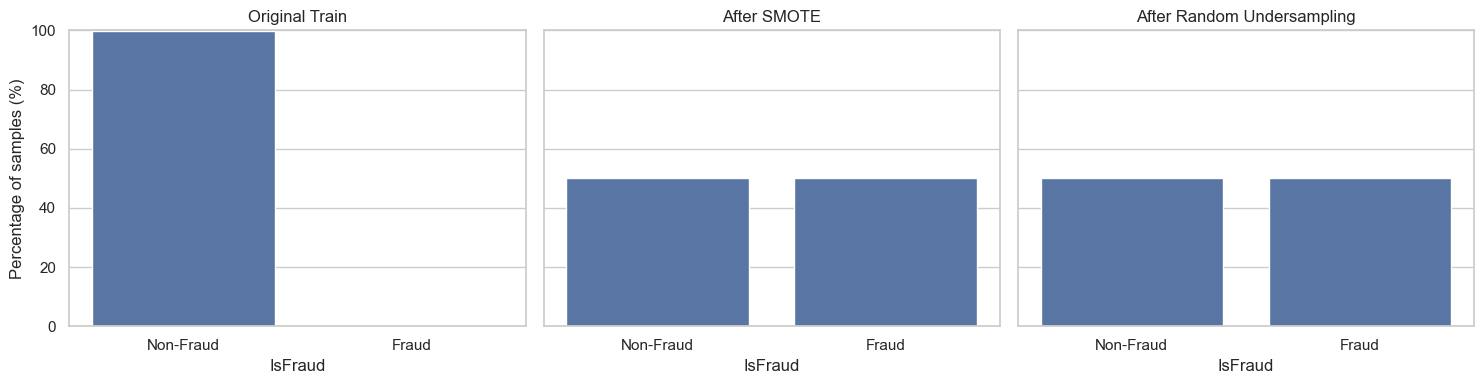

In [5]:
# Compare class distributions before and after resampling (as percentages)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

counts_original = y_train.value_counts().rename(index={0: 'Non-Fraud', 1: 'Fraud'})
counts_smote = pd.Series(y_train_smote).value_counts().rename(index={0: 'Non-Fraud', 1: 'Fraud'})
counts_rus = pd.Series(y_train_rus).value_counts().rename(index={0: 'Non-Fraud', 1: 'Fraud'})

props_original = 100 * counts_original / counts_original.sum()
props_smote = 100 * counts_smote / counts_smote.sum()
props_rus = 100 * counts_rus / counts_rus.sum()

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

sns.barplot(x=props_original.index, y=props_original.values, ax=axes[0])
axes[0].set_title('Original Train')
axes[0].set_ylabel('Percentage of samples (%)')
axes[0].set_ylim(0, 100)

sns.barplot(x=props_smote.index, y=props_smote.values, ax=axes[1])
axes[1].set_title('After SMOTE')
axes[1].set_ylabel('Percentage of samples (%)')
axes[1].set_ylim(0, 100)

sns.barplot(x=props_rus.index, y=props_rus.values, ax=axes[2])
axes[2].set_title('After Random Undersampling')
axes[2].set_ylabel('Percentage of samples (%)')
axes[2].set_ylim(0, 100)

for ax in axes:
    ax.set_xlabel('IsFraud')

plt.tight_layout()

# Save figure
fig.savefig(FIGURES_DIR / '03_resampling_comparison.png', dpi=300, bbox_inches='tight')
print(f"Saved figure to: {FIGURES_DIR / '03_resampling_comparison.png'}")

plt.show()

In [6]:
# Summary table of class counts before and after resampling

summary = pd.DataFrame({
    'Dataset': ['Original train', 'After SMOTE', 'After Random Undersampling'],
    'Total samples': [
        len(y_train),
        len(y_train_smote),
        len(y_train_rus),
    ],
    'Non-Fraud count (0)': [
        (y_train == 0).sum(),
        (y_train_smote == 0).sum(),
        (y_train_rus == 0).sum(),
    ],
    'Fraud count (1)': [
        (y_train == 1).sum(),
        (y_train_smote == 1).sum(),
        (y_train_rus == 1).sum(),
    ],
})

summary['Fraud %'] = 100 * summary['Fraud count (1)'] / summary['Total samples']

# Save summary table
summary.to_csv(METRICS_DIR / '03_resampling_summary.csv', index=False)
print(f"Saved resampling summary to: {METRICS_DIR / '03_resampling_summary.csv'}")

summary

Saved resampling summary to: ..\results\metrics\03_resampling_summary.csv


,Dataset,Total samples,Non-Fraud count (0),Fraud count (1),Fraud %
0,Original train,227845,227451,394,0.172925
1,After SMOTE,454902,227451,227451,50.000000
2,After Random Undersampling,788,394,394,50.000000


In [7]:
# Save resampled datasets for later models

# Wrap numpy arrays into DataFrames/Series before saving
X_train_smote_df = pd.DataFrame(X_train_smote, columns=X_train.columns)
y_train_smote_ser = pd.Series(y_train_smote, name='IsFraud')
X_train_rus_df = pd.DataFrame(X_train_rus, columns=X_train.columns)
y_train_rus_ser = pd.Series(y_train_rus, name='IsFraud')

X_train_smote_df.to_csv(PROCESSED_DIR / 'X_train_smote.csv', index=False)
y_train_smote_ser.to_csv(PROCESSED_DIR / 'y_train_smote.csv', index=False)
X_train_rus_df.to_csv(PROCESSED_DIR / 'X_train_rus.csv', index=False)
y_train_rus_ser.to_csv(PROCESSED_DIR / 'y_train_rus.csv', index=False)

Rationale: SMOTE synthesizes minority class samples to reduce bias, but applying it only to the training set prevents inflating performance on unseen data. Undersampling offers a simpler baseline. Class weights remain available for algorithms that natively support them.